## Normal VAE

In [8]:
import inspect
import os

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax import jit
from jax import lax
from jax import random
from jax.example_libraries import stax
from jax.random import PRNGKey
from numpyro import optim
from numpyro.examples.datasets import MNIST
from numpyro.examples.datasets import load_dataset
import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp


import genjax
from genjax import nablasp
from genjax import gensp
from genjax import select

import adevjax


RESULTS_DIR = os.path.abspath(
    os.path.join(os.path.dirname(inspect.getfile(lambda: None)), ".results")
)
os.makedirs(RESULTS_DIR, exist_ok=True)

hidden_dim = 400
z_dim = 10
learning_rate = 1.0e-3
batch_size = 64
num_epochs = 50


def encoder(hidden_dim, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()),
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp),
        ),
    )


def decoder(hidden_dim, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.Dense(out_dim, W_init=stax.randn()),
    )


tfp_flip = genjax.TFPDistribution(
    lambda logits: tfp.distributions.Bernoulli(logits=logits)
)

# Define our gradient estimator using our loss language.
def svi_update(
    model,
    guide,
    optimizer,
):
    def _inner(key, encoder_params, decoder_params, data):
        img_chm = genjax.value_choice_map(
            genjax.choice_map({"image": data.reshape((28 * 28,))})
        )

        @adevjax.adev
        def elbo_loss(encoder_params, decoder_params):
            key = adevjax.grab_key()
            w_q, latent_chm = guide.random_weighted(key, encoder_params, img_chm)
            merged = gensp.merge(latent_chm, img_chm)
            key = adevjax.grab_key()
            w_p = model.estimate_logpdf(key, merged, decoder_params)
            return w_p - w_q

        # @dippl.loss
        # def vae_loss(encoder, decoder):
        #    tgt = gensp.target(model, (decoder, ), img_chm)
        #    key = adevjax.grab_key()
        #    w = dippl.iwae_importance(10, guide, (encoder, v_chm)).estimate_normalizing_constant(key, tgt)
        #    return w

        loss, (encoder_params_grad, decoder_params_grad,) = adevjax.E(
            elbo_loss
        ).value_and_grad_estimate(key, (encoder_params, decoder_params))

        return (encoder_params_grad, decoder_params_grad), loss

    def batch_update(key, svi_state, batch):
        encoder_params, decoder_params = optimizer.get_params(svi_state)
        sub_keys = jax.random.split(key, len(batch))
        (encoder_grads, decoder_grads), loss = jax.vmap(
            _inner, in_axes=(0, None, None, 0)
        )(sub_keys, encoder_params, decoder_params, batch)
        encoder_grads, decoder_grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0), (encoder_grads, decoder_grads)
        )
        svi_state = optimizer.update(
            (encoder_grads, decoder_grads),
            svi_state,  # just (encoder_params, decoder_params)
        )
        return svi_state, jnp.mean(loss)

    return batch_update


@jit
def binarize(rng_key, batch):
    return random.bernoulli(rng_key, batch).astype(batch.dtype)


encoder_nn_init, encoder_nn_apply = encoder(hidden_dim, z_dim)
decoder_nn_init, decoder_nn_apply = decoder(hidden_dim, 28 * 28)

# Model + guide close over the neural net apply functions.
@genjax.gen
def decoder_model(decoder_params):
    latent = genjax.tfp_mv_normal_diag(jnp.zeros(z_dim), jnp.ones(z_dim)) @ "latent"
    logits = decoder_nn_apply(decoder_params, latent)
    _ = genjax.tfp_bernoulli(logits) @ "image"


model = gensp.choice_map_distribution(decoder_model)


@genjax.gen
def encoder_model(encoder_params, chm):
    image = chm.get_leaf_value()["image"]
    μ, Σ_scale = encoder_nn_apply(encoder_params, image)
    _ = nablasp.mv_normal_diag_reparam(μ, Σ_scale) @ "latent"


guide = gensp.choice_map_distribution(encoder_model)

adam = optim.Adam(learning_rate)
svi_updater = svi_update(model, guide, adam)
train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
num_train, train_idx = train_init()
rng_key = PRNGKey(0)
encoder_init_key, decoder_init_key = random.split(rng_key)
_, encoder_params = encoder_nn_init(encoder_init_key, (784,))
_, decoder_params = decoder_nn_init(decoder_init_key, (z_dim,))
num_train, train_idx = train_init()


@jit
def epoch_train(svi_state, key1, key2, train_idx):
    def body_fn(carry, xs):
        idx, svi_state, loss = carry
        rng_key_binarize = random.fold_in(key1, idx)
        batch = binarize(rng_key_binarize, train_fetch(idx, train_idx)[0])
        updater_key = random.fold_in(key2, idx)
        svi_state, loss = svi_updater(updater_key, svi_state, batch)
        idx += 1
        return (idx, svi_state, loss), loss

    idx = 0
    (_, svi_state, _), losses = lax.scan(
        body_fn, (idx, svi_state, 0.0), None, length=num_train
    )
    return svi_state, losses


# Train.
key = random.PRNGKey(314159)
svi_state = adam.init((encoder_params, decoder_params))
for _ in range(0, num_epochs):
    key, key1, key2 = jax.random.split(key, 3)
    num_train, train_idx = train_init()
    svi_state, loss = epoch_train(svi_state, key1, key2, train_idx)
    print(jnp.mean(loss), jnp.max(loss), jnp.min(loss))

-187.93683 -144.51834 -547.5518
-139.85727 -118.564735 -169.98514
-123.77806 -109.60018 -139.81021
-118.91979 -106.06482 -132.41243
-116.35184 -104.01479 -131.79811
-114.69463 -102.30388 -130.27652
-113.44112 -98.60271 -127.18927
-112.491615 -99.09976 -125.307045
-111.76993 -100.36415 -129.1171
-111.16662 -98.11888 -124.34346
-110.5944 -98.047516 -124.48819
-110.06027 -96.33754 -124.5229
-109.5917 -95.3978 -124.2038
-109.114815 -95.299706 -121.260666
-108.67189 -94.92757 -122.95674
-108.33361 -96.40257 -119.856186
-107.9306 -96.775154 -119.23195
-107.578476 -96.47286 -119.86563
-107.33212 -93.09282 -120.17706
-107.03577 -94.34917 -118.64399
-106.69416 -94.38687 -123.18965
-106.41662 -93.07442 -119.54758
-106.21359 -92.49185 -118.49284
-105.96578 -93.572914 -120.898605
-105.680405 -91.41397 -118.411606
-105.53937 -91.37651 -118.02678
-105.31824 -92.12115 -120.74809
-105.07397 -92.26828 -118.74666
-104.904274 -95.018585 -117.779755
-104.77623 -93.3788 -115.33646
-104.638824 -91.705025 -1

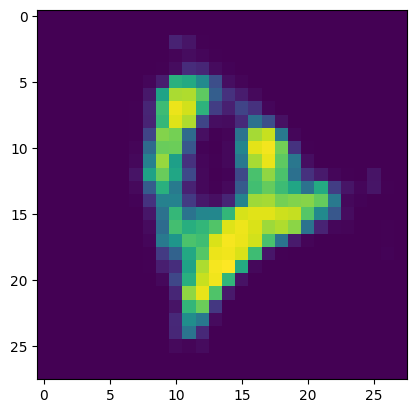

In [19]:
key, sub_key = jax.random.split(key)
_, updated_decoder_params = adam.get_params(svi_state)
latent = genjax.tfp_mv_normal_diag.sample(key, jnp.zeros(z_dim), jnp.ones(z_dim))
updated_out = jax.nn.sigmoid(decoder_nn_apply(updated_decoder_params, latent)).reshape(
    28, 28
)
plt.imshow(updated_out)

## IWAE

# Define our gradient estimator using our loss language.
def iwae_svi_update(
    model,
    guide,
    optimizer,
):
    def _inner(key, encoder_params, decoder_params, data):
        img_chm = genjax.choice_map({"image": data.reshape((28 * 28,))})
        v_chm = genjax.value_choice_map(img_chm)

        @adevjax.adev
        def iwae_elbo_loss(encoder_params, decoder_params):
            tgt = gensp.target(model, (decoder_params,), img_chm)
            key = adevjax.grab_key()
            w = nablasp.iwae_importance(
                10, guide, (encoder_params, v_chm)
            ).estimate_normalizing_constant(key, tgt)
            return w

        loss, (encoder_params_grad, decoder_params_grad) = adevjax.E(
            iwae_elbo_loss
        ).value_and_grad_estimate(key, (encoder_params, decoder_params))

        return (encoder_params_grad, decoder_params_grad), loss

    def batch_update(key, svi_state, batch):
        encoder_params, decoder_params = optimizer.get_params(svi_state)
        sub_keys = jax.random.split(key, len(batch))
        (encoder_grads, decoder_grads), loss = jax.vmap(
            _inner, in_axes=(0, None, None, 0)
        )(sub_keys, encoder_params, decoder_params, batch)
        encoder_grads, decoder_grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0), (encoder_grads, decoder_grads)
        )
        svi_state = optimizer.update(
            (encoder_grads, decoder_grads),
            svi_state,  # just (encoder_params, decoder_params)
        )
        return svi_state, jnp.mean(loss)

    return batch_update


adam = optim.Adam(learning_rate)
iwae_svi_updater = iwae_svi_update(decoder_model, guide, adam)

# Reset training.
train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
num_train, train_idx = train_init()
rng_key = PRNGKey(0)
encoder_init_key, decoder_init_key = random.split(rng_key)
_, encoder_params = encoder_nn_init(encoder_init_key, (784,))
_, decoder_params = decoder_nn_init(decoder_init_key, (z_dim,))
num_train, train_idx = train_init()


@jit
def epoch_train(svi_state, key1, key2, train_idx):
    def body_fn(carry, xs):
        idx, svi_state, loss = carry
        rng_key_binarize = random.fold_in(key1, idx)
        batch = binarize(rng_key_binarize, train_fetch(idx, train_idx)[0])
        updater_key = random.fold_in(key2, idx)
        svi_state, loss = iwae_svi_updater(updater_key, svi_state, batch)
        idx += 1
        return (idx, svi_state, loss), loss

    idx = 0
    (_, svi_state, _), losses = lax.scan(
        body_fn, (idx, svi_state, 0.0), None, length=num_train
    )
    return svi_state, losses


# Train.
key = random.PRNGKey(314159)
svi_state = adam.init((encoder_params, decoder_params))
for _ in range(0, num_epochs):
    key, key1, key2 = jax.random.split(key, 3)
    num_train, train_idx = train_init()
    svi_state, loss = epoch_train(svi_state, key1, key2, train_idx)
    print(jnp.mean(loss), jnp.max(loss), jnp.min(loss))

In [ ]:
key, sub_key = jax.random.split(key)
_, updated_decoder_params = adam.get_params(svi_state)
latent = genjax.tfp_mv_normal_diag.sample(key, jnp.zeros(z_dim), jnp.ones(z_dim))
updated_out = jax.nn.sigmoid(decoder_nn_apply(updated_decoder_params, latent)).reshape(
    28, 28
)
plt.imshow(updated_out)